# COMP47670 Data Science with Python Assignment 1 Notebook 2

### Irem Erkilic 24220454

##  Task 2: Data Preparation and Analysis

In this assignment, I used Retail Sale Records http://mlg.ucd.ie/modules/python/assignment1/retail/index.html.  I started with scraped sales dataset and noticed some issues with missing demographics - about 80+ missing locations and genders, which could be spurious for our analysis later. Rather than dropping those records (which would lose valuable sales data), I just marked them as "Unknown" so we can still include them. Next, I checked for any duplicate entries since those would skew our numbers. For the dates, they were stored as strings, making time analysis impossible. After converting them to proper datetime format, I extracted useful time components like months and weekdays, and added a weekend flag that'll help us see if shopping patterns differ on weekends. For customer segmentation, I consolidated our age categories into broader groups (like combining 35-44 and 45-54 into "Middle Age") which should make demographic trends more obvious. I also calculated profit margins for each transaction as a percentage - that'll be helpful when comparing performance across different price points. Finally, I replaced the payments logged as 'CC' with 'Credit Card' to standardise the payment methods. 

### Further Pre-processing and Cleaning 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the raw dataset
sales_data = pd.read_csv('sales_data.csv')  # Using correct filename

# Handle missing demographic values
print("\nMissing values before handling:")
print(sales_data.isnull().sum()[sales_data.isnull().sum() > 0])

# Create an "Unknown" category for transparency
sales_data['Location'] = sales_data['Location'].fillna('Unknown')
sales_data['Gender'] = sales_data['Gender'].fillna('Unknown')
sales_data['Age Category'] = sales_data['Age Category'].fillna('Unknown')

# Print the missing values
print("\nMissing values after handling:")
print(sales_data.isnull().sum()[sales_data.isnull().sum() > 0])


Missing values before handling:
Location        84
Gender          87
Age Category    44
dtype: int64

Missing values after handling:
Series([], dtype: int64)


In [3]:
# Check for duplicates
duplicates = sales_data.duplicated().sum()
if duplicates > 0:
    print(f"\nFound {duplicates} duplicate records")
    sales_data = sales_data.drop_duplicates()
    print(f"Removed duplicates. New shape: {sales_data.shape}")

# Make sure Date of Sale is in datetime format
sales_data['Date of Sale'] = pd.to_datetime(sales_data['Date of Sale'])

# Create temporal features
sales_data['Month'] = sales_data['Date of Sale'].dt.month  # Keep numeric month
sales_data['Month_Name'] = sales_data['Date of Sale'].dt.month_name()  # Add named month
sales_data['Quarter'] = sales_data['Date of Sale'].dt.quarter
sales_data['Day'] = sales_data['Date of Sale'].dt.day
sales_data['Weekday'] = sales_data['Date of Sale'].dt.day_name()
sales_data['Weekend'] = sales_data['Date of Sale'].dt.dayofweek >= 5

# Replace 'CC' with 'Credit Card'
sales_data['Payment Type'] = sales_data['Payment Type'].replace('CC', 'Credit Card')

# Create age group categories
age_mapping = {
    '18-24': 'Young Adult',
    '25-34': 'Adult',
    '35-44': 'Middle Age',
    '45-54': 'Middle Age',
    '55-64': 'Senior',
    '65+': 'Senior',
    'Unknown': 'Unknown'
}
sales_data['Age Group'] = sales_data['Age Category'].map(age_mapping)

# Add profit margin calculation
sales_data['Profit Margin %'] = (sales_data['Total Profit'] / sales_data['Total Price']) * 100

# Display dataset information
print(f"\nDataset shape: {sales_data.shape}")
print(f"Date range: {sales_data['Date of Sale'].min()} to {sales_data['Date of Sale'].max()}")

# Display the cleaned dataset
print("\nCleaned dataset preview:")
print(sales_data.head())

# Save to CSV
sales_data.to_csv('cleaned_sales_data.csv', index=False)
print("\nCleaned data saved to 'cleaned_sales_data.csv'")


Dataset shape: (1800, 22)
Date range: 2024-01-01 00:00:00 to 2024-12-23 00:00:00

Cleaned dataset preview:
                                          source_url Date of Sale  \
0  http://mlg.ucd.ie/modules/python/assignment1/r...   2024-01-01   
1  http://mlg.ucd.ie/modules/python/assignment1/r...   2024-01-01   
2  http://mlg.ucd.ie/modules/python/assignment1/r...   2024-01-01   
3  http://mlg.ucd.ie/modules/python/assignment1/r...   2024-01-01   
4  http://mlg.ucd.ie/modules/python/assignment1/r...   2024-01-01   

                                      Product     Product Category  Quantity  \
0             White Short Sleeve Oxford Shirt         Men → Shirts         1   
1         Black Skinny Fit Jeans with Stretch          Men → Jeans         1   
2  1000 Thread Count Cotton Sateen Collection  Homeware → Bed Bath         3   
3          Black Loose Fit Jeans with Stretch          Men → Jeans         1   
4                               Mola Headlamp    Homeware → Design         2 

### Analysis

I started data analysis with a generic visualisation: monthly sales trends. I used a simple plot to show monthly total sales (€) including all quarters. The plot shows that the total sales peaked in March, i.e. end of Q1. 

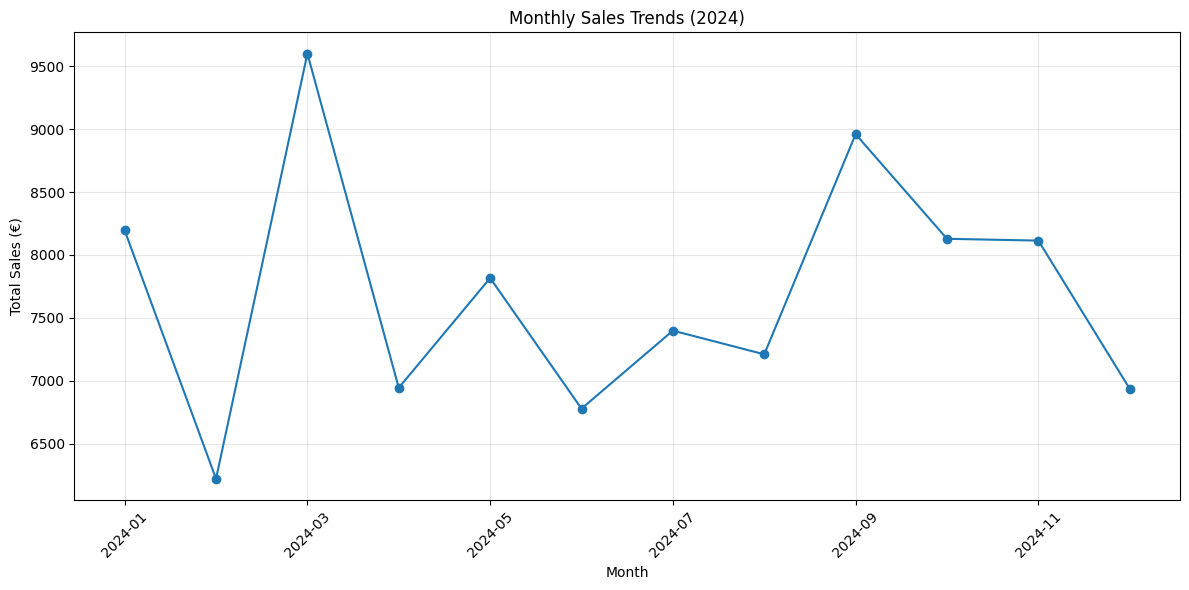

In [4]:
# Load your cleaned dataset
sales_data = pd.read_csv('cleaned_sales_data.csv')

# Ensure Date of Sale is datetime 
sales_data['Date of Sale'] = pd.to_datetime(sales_data['Date of Sale'])

# Create monthly sales trends visualization
plt.figure(figsize=(12, 6))
monthly_sales = sales_data.groupby(sales_data['Date of Sale'].dt.to_period('M'))['Total Price'].sum()
monthly_sales.index = monthly_sales.index.astype(str)  # Convert period to string for plotting
monthly_sales.plot(kind='line', marker='o')

plt.title('Monthly Sales Trends (2024)')
plt.xlabel('Month')
plt.ylabel('Total Sales (€)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


I did a scatter plot which shows which kind of products or purchases different age group did over time. The data reveals that Middle Age consumers demonstrate the strongest preference for Men's products, with approximately 300 purchases, making this the highest-volume segment in the entire dataset. Children's merchandise shows strong performance among both Adult and Middle Age demographics (approximately 280 purchases each), which likely represents parents purchasing for their dependents. Also, Young Adult consumers show moderate engagement, with their strongest preference being for Men's products.

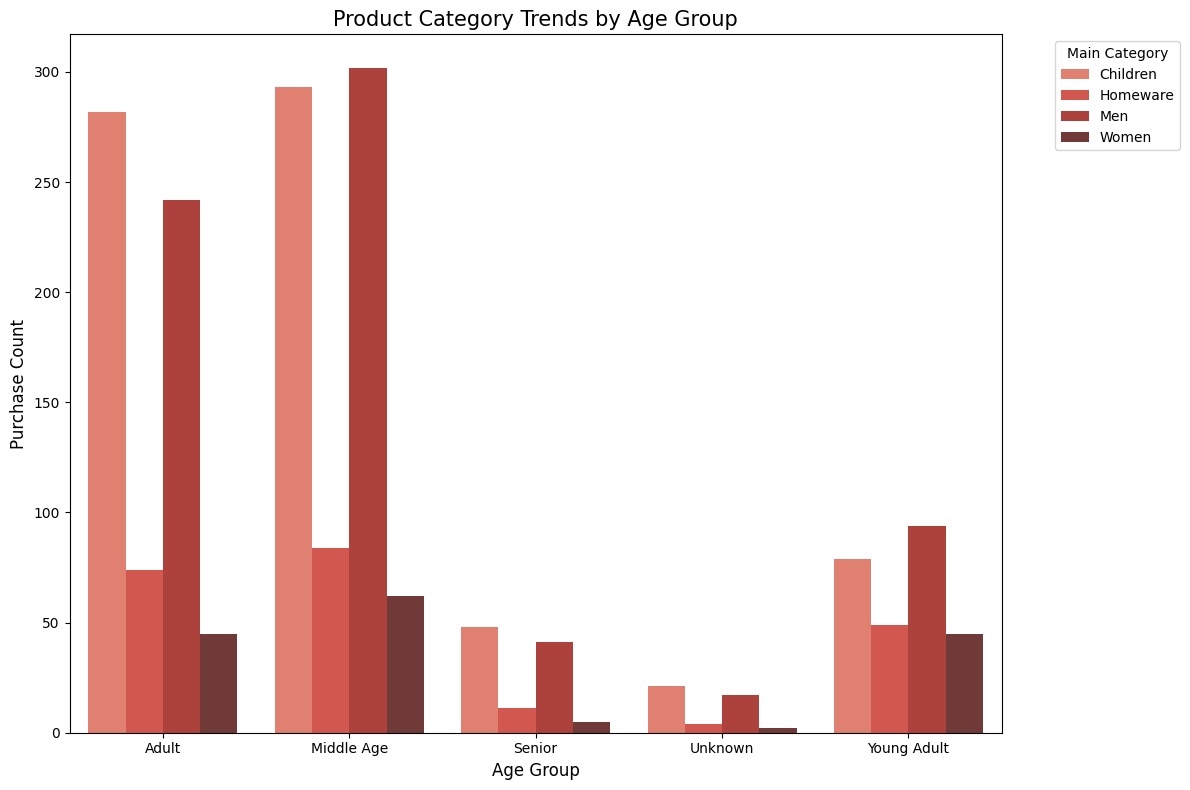

In [5]:
# Group by Main Category and Age Group to get purchase counts
category_age_counts = sales_data.groupby(['Main Category', 'Age Group']).size().reset_index(name='Purchase Count')

# Create a grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=category_age_counts, x='Age Group', y='Purchase Count', hue='Main Category', palette='Reds_d')

plt.title('Product Category Trends by Age Group', fontsize=15)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Purchase Count', fontsize=12)
plt.legend(title='Main Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Moreover, when we see the heatmap of profit margin by category, Women's Shoes are  55.7% profit margin - significantly higher than most other products. Also, both Boys Wear (50.2%) and Design items (50.7%) seem to be profitable. It's worth noting that Homeware has the most lowest profit profile, with Bed Bath items returning just 33.3% - the lowest margin in the entire dataset. 

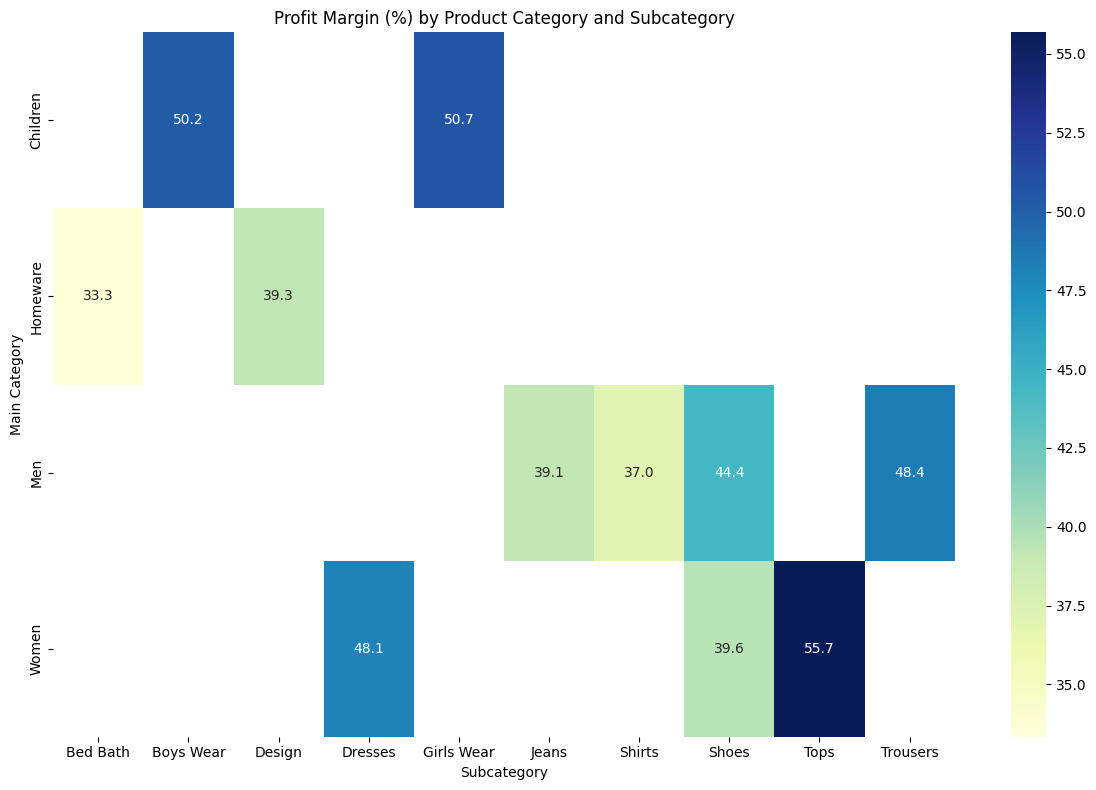

In [6]:
# Calculate average profit margin by category and subcategory
category_subcategory_profit = sales_data.pivot_table(
    values='Profit Margin %', 
    index='Main Category', 
    columns='Subcategory', 
    aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(category_subcategory_profit, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Profit Margin (%) by Product Category and Subcategory')
plt.tight_layout()
plt.show()


Lastly, I did a basic demographic analysis using a pie chart that includes gender distribution. The gender spending chart reveals an intriguing pattern: Women's products generate the lowest sales despite having the highest profit margins (Women's Shoes at 55.7%). Interestingly, female customers spend substantially more on Men's products (€20,000) than on Women's items (€3,500). This creates a notable disconnect - highly profitable Women's merchandise fails to achieve proportional sales volume. Male customers predominantly purchase Men's items as expected, but the data suggests female customers are mainly shopping for family members rather than themselves. This presents a clear opportunity to investigate why Women's products with excellent margins aren't achieving better sales performance.

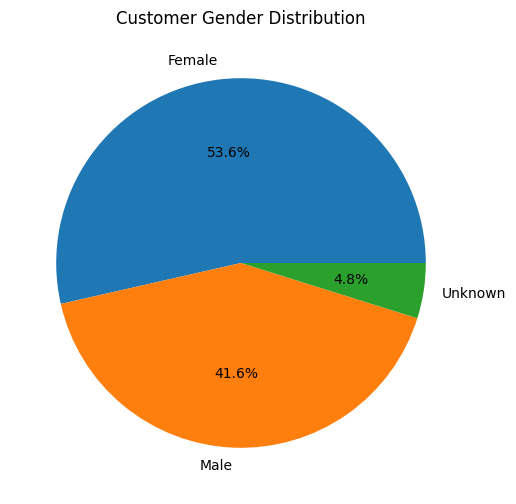

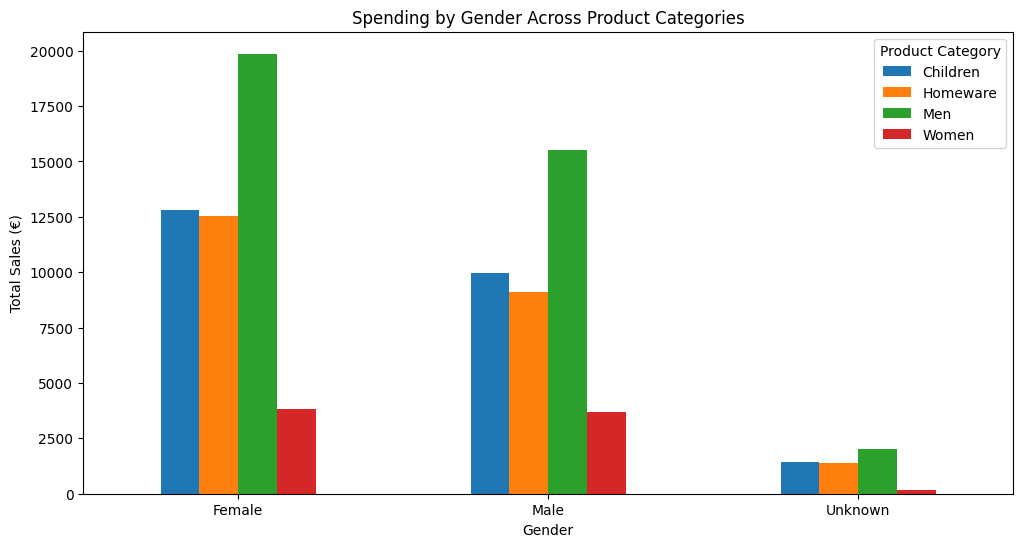

In [7]:
# Gender distribution
plt.figure(figsize=(10, 6))
sales_data['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Customer Gender Distribution')
plt.ylabel('')
plt.show()

# Purchase patterns by gender
gender_category = sales_data.groupby(['Gender', 'Main Category'])['Total Price'].sum().unstack()
gender_category.plot(kind='bar', figsize=(12, 6))
plt.title('Spending by Gender Across Product Categories')
plt.xlabel('Gender')
plt.ylabel('Total Sales (€)')
plt.xticks(rotation=0)
plt.legend(title='Product Category')
plt.show()


## Task 3: Discussion

Firstly, getting data from the website was challenging because each sale was stored in separate tables instead of one organized dataset. The data collector often timed out when trying to process all 62 pages, so I had to add waiting periods between requests.

Customer information was also moderately difficult to work with. The data came in untidy formats like "ID: 3375Location: DublinGender: MaleAge Category: 18-24" with no clear separators. I wrote special patterns to extract this information correctly. I also found many missing details - 84 locations, 87 genders, and 44 age categories were missing and needed to be handled carefully.

Dates were inconsistent, sometimes appearing as "01/01/2024" and other times as "14/January/2024." Payment methods were also recorded differently, with credit cards shown as either "Credit Card" or just "CC."

When it comes to the insights that I derived from the dataset, Women's Shoes stand out with an impressive 55.7% profit margin, much higher than other products. Children's items also do well, with Boys Wear and Design both earning over 50% margins. This shows the store can charge premium prices in these areas.

Middle-aged adults and regular adults make the most purchases, especially of Men's products, even though these have lower profit margins. The wide range in profitability (from 33% to nearly 56%) suggests the store could improve pricing in some areas.

It's interesting that Women's products have high profit margins but lower sales volumes. This might point to problems with product selection, marketing, or how these items are displayed in the store.

To build upon the current findings, I may recommend five key areas for further analysis. Examining seasonal trends in product preferences and margins would improve inventory planning and promotions. Also, analysing further geographic purchasing patterns could reveal regional preferences for targeted marketing. Market basket analysis would identify commonly paired purchases, optimizing store layouts and bundling opportunities. Integrating external data like local demographics and economic indicators would contextualize sales patterns. These approaches would transform our analysis into actionable business intelligence for more effective decision-making.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=430c697a-6a7e-401e-9d0a-5bd226fea66f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>